# Creating a neural network from scratch

In [2]:
import numpy as np 

In [3]:
class Layer:
    """
    Base class for layers in the network
    
    Arguments:
        `inbound_layers`: A list of layers with edges into this class
    """
    def __init__(self, inbound_layers = []):
        
        # The list of layers with edges into the class
        self.inbound_layers = inbound_layers
        
        # The value of this layer which is calculated during the forward pass
        self.value = None
        
        # The layers that the this layer outputs to
        self.outbound_layers = []
        
        # The gradients for this layer
        # The keys are the input to this layer and their values are the 
        # partials of this layer with respect to that layer 
        self.gradients = {}
        
        # Sets this layer as an outbound layer for all of this layer's inputs
        for layer in inbound_layers: 
            layer.outbound_layers.append(self)
        
    def forward(debug = False):
        # Abstract method that should be implemented for all the derived classes
        raise NotImplementedError
        
    def backward():
        # Abstract method that should be implemented for all the derived classes 
        raise NotImplementedError

In [4]:
class Input(Layer):
    """
    This layer accepts inputs to the neural network
    """
    def __init__(self):
        # Note here that nothing is set because these values are set during
        # the topological sort
        Layer.__init__(self)
        
    def forward(self, debug = False):
        # Do nothing because nothing is calculated
        pass
    
    def backward(self, debug = False):
        # An Input layer has no inputs so the gradient is zero 
        self.gradients = {self : 0}
        
        # Weights and bias may be inputs, so we need to sum the gradients 
        # from their outbound layers during the backward pass.
        
        # Remember that the goal is to figure out the total change in the cost function
        # with respect to a single parameter, hence the addition
  
        for n in self.outbound_layers:
#             a = self.gradients[self]
#             print(a)
#             b = n.gradients[self]
#             print(b)
            self.gradients[self] += n.gradients[self] 

In [5]:
class Linear(Layer):
    def __init__(self, X, W, b):
        Layer.__init__(self, [X, W, b])
    
    def forward(self, debug = False):
        X = self.inbound_layers[0].value
        W = self.inbound_layers[1].value
        b = self.inbound_layers[2].value
        self.value = np.dot(X, W) + b
       
        if debug:
            print("Input to layer is:")
            print(X)

            print("Weights of layer is:")
            print(W)

            print("Bias of layer is:")
            print(b)
            
            print("XW + b is:")
            print(self.value)
            
    def backward(self, debug = False):
        
        # Initialize a partial derivative for each of the inbound_layers,
        # remembering here that this dictionary stores the partial derivative of
        # this layer with respect to the inbound layers
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_layers}
        
        for n in self.outbound_layers:
            # Get the partial derivative for each of the variables in this layer 
            # with respect to the cost
            grad_cost = n.gradients[self]
            
            if debug:
                print("grad_cost is:") 
                print(grad_cost)
                
            
            
            self.gradients[self.inbound_layers[0]] += np.dot(grad_cost, self.inbound_layers[1].value.T) 
           
            self.gradients[self.inbound_layers[1]] += np.dot(self.inbound_layers[0].value.T, grad_cost)
              
            self.gradients[self.inbound_layers[2]] += np.sum(grad_cost, axis = 0, keepdims = False)
        
        if debug:
            print("The derivatives of the cost with respect to the inputs are:")
            print(self.gradients[self.inbound_layers[0]])
            
            print("The derivatives of the cost with respect to the weights are:")
            print(self.gradients[self.inbound_layers[1]])
            
            print("The derivatives of the cost with respect to the biases are:")
            print(self.gradients[self.inbound_layers[2]])
            
    

In [6]:
class Sigmoid(Layer):
    def __init__(self, layer):
        Layer.__init__(self, [layer])
        
    def _sigmoid(self, x):
        return 1./(1. + np.exp(-x))
    
    def forward(self, debug = False):
        
        self.value = self._sigmoid(self.inbound_layers[0].value)
            
        if debug:
            print("Input to sigmoid layer is:")
            print(self.inbound_layers[0].value)
            
            print("Value after sigmoid activation is:")
            print(self.value)
            
        
    def backward(self, debug = False):
        self.gradients = {n : np.zeros_like(n.value) for n in self.inbound_layers}
        
        for n in self.outbound_layers:
            grad_cost = n.gradients[self]
            sigmoid = self.value
            self.gradients[self.inbound_layers[0]] += sigmoid * (1 - sigmoid) * grad_cost
        
        if debug:
            print("The derivatives of the cost with respect to the sigmoid activation is:")
            print(self.gradients[self.inbound_layers[0]])
        

In [7]:
class MSE(Layer):
    def __init__(self, y, a):
        Layer.__init__(self, [y, a])
        
    def forward(self, debug = False):
        y = self.inbound_layers[0].value.reshape(-1, 1)
        a = self.inbound_layers[1].value.reshape(-1, 1) 
    
        # get the number of samples
        self.m = self.inbound_layers[0].value.shape[0] 
        self.diff = y - a
        self.value = np.mean(self.diff**2)
 
        if debug:
            print("True value of y is:")
            print(y)

            print("Predicted value of y is:")
            print(a)
             
            print("y - a is:")
            print(self.diff)

       
    def backward(self, debug = False):
        self.gradients[self.inbound_layers[0]] = (2/self.m) * self.diff
        self.gradients[self.inbound_layers[1]] = (-2/self.m) * self.diff

In [94]:
class Softmax(Layer):
    def __init__(self, logits):
        Layer.__init__(self, [logits])
    
    def forward(self, debug = False):
        
        logits = self.inbound_layers[0].value
        logit_max = np.reshape(np.max(self.inbound_layers[0].value, axis = 1), (-1, 1))
        self.inbound_layers[0].value -= logit_max
        exp_logits = np.exp(self.inbound_layers[0].value)
        sum_exp = np.reshape(np.sum(exp_logits, axis = 1), (-1, 1))
        self.value = exp_logits/sum_exp
        
        if debug:
            print("Logits are:")
            print(self.inbound_layers[0].value) 
            
            print("sum_exp:")
            print(sum_exp)
            
            print("Logits max are:")
            print(np.reshape(np.max(self.inbound_layers[0].value, axis = 1), (-1, 1)))
            
            print("After exponents are:")
            exp_logits = np.exp(self.inbound_layers[0].value)
            print(exp_logits)
            
            print("Probabilities are:")
            sum_exp = np.sum(exp_logits)  
            self.value = exp_logits/sum_exp 
            print(self.value)
             
            
    
    def backward(self, debug = False):
         
        # Define gradient for inbound layers
        self.gradients = {n : np.zeros_like(n.value) for n in self.inbound_layers}
        jacobian = self._calc_jacobian(self.value)
        for n in self.outbound_layers:
            grad_cost = n.gradients[self]
            if debug:
                print("grad_cost is:")
                print(grad_cost)
                print("The Jacobian is:")
                print(jacobian)
            
            self.gradients[self.inbound_layers[0]] += np.dot(grad_cost, jacobian)
        
 
        if debug: 
            print("The derivative of the cost with respect to the inputs of the softmax layer is:")
            print(self.gradients[self.inbound_layers[0]])
       
    def _calc_jacobian(self, probs):
        
        # First calculate the off diagonal derivatives
        jacobian = np.dot(-1 * probs.T, probs)
        dims = jacobian.shape[0]
        
        # Now calculate the diagonal derivatives
        for i in range(dims):
            jacobian[i,i] = probs[0,i] * (1 - probs[0,i])
        return(jacobian)

In [95]:
class CrossEntropy(Layer):
    def __init__(self, y, probs):
        Layer.__init__(self, [y, probs])
    
    def forward(self, debug = False):
        n_samples_in_batch = self.inbound_layers[0].value.shape[0]
        n_classes = self.inbound_layers[0].value.shape[1]
        
        self.y_flat = self.inbound_layers[0].value.reshape(n_samples_in_batch, n_classes)
        self.probs_flat = self.inbound_layers[1].value.reshape(n_samples_in_batch, n_classes)
       
        # Calculate the accuracy
        n_correct = np.sum(np.argmax(self.y_flat, axis = 1) == np.argmax(self.probs_flat, axis = 1))
        self.accuracy = n_correct/n_samples_in_batch
        
        # Calculate the cross entropy
        self.log_probs = np.log(self.probs_flat)
        self.cross_entropy = self.y_flat * self.log_probs
        self.value = -1 * np.sum(self.cross_entropy)
       
        
        if debug:
            print("True values y are:")
            print(self.y_flat)
            print("Probabilities are:")
            print(self.probs_flat)
            print("True value y max index are:")
            print(np.argmax(self.y_flat, axis = 1))
            print(np.argmax(self.y_flat, axis = 1).shape)
            print("Probabilities max index are:")
            print(np.argmax(self.probs_flat, axis = 1))
            print(np.argmax(self.probs_flat, axis = 1).shape) 
            print("Log probabilities are:")
            print(self.log_probs)
            print("Cross entropy is:")
            print(self.cross_entropy)
            print("Cross entropy sum is")
            print(self.value)

            
        
    
    def backward(self, debug = False):
        self.gradients[self.inbound_layers[0]] = -1 * 1/self.probs_flat
        self.gradients[self.inbound_layers[1]] = -1 * self.y_flat/self.probs_flat
        
        if debug:
            print("Gradients of cross entropy with respect to y layer is:")
            print(self.gradients[self.inbound_layers[0]])
            print("Gradients of cross entropy with respect to softmax layer is:")
            print(self.gradients[self.inbound_layers[1]])
        

In [96]:
def topological_sort(feed_dict):
    input_layers = [n for n in feed_dict.keys()]
    
    G = {}
    
    layers = [n for n in input_layers]
    
    # Think of each element in the layer as a node, in this while loop
    # we are simply finding which layers are connected to which other layers
    while len(layers) > 0:
        # Get the first element of the array
        n = layers.pop(0)
        
        # Check if this layer n is in the dictionary if it isn't add it in
        if n not in G:
            G[n] = {'in' : set(), 'out' : set()}
        # Check if this layer m is in the dictionary if it isn't add it in 
        for m in n.outbound_layers:
            if m not in G:
                G[m] = {'in' : set(), 'out' : set()}
            # Add the edges between the nodes
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            layers.append(m)
        
    L = []
    S = set(input_layers)
    
    while len(S) > 0:
        # Get the last layer 
        n = S.pop()
        
        # Check if it is an input layer, if it is then initialize the value
        if (isinstance(n, Input)):
            n.value = feed_dict[n]
            
        L.append(n)
        for m in n.outbound_layers:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            
            # if there are no incoming edges to m then add it to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return(L)

In [88]:
def forward_pass(graph, debug = False):
    for n in graph:
        n.forward(debug)

def backward_pass(graph, debug = False):
    for n in graph[::-1]:
        n.backward(debug) 

In [89]:
def sgd_update(trainable, learning_rate = 1e-2): 
     
    for t in trainable:
        partial = t.gradients[t]
#         print("Partial derivatives are:")
#         print(partial)
        t.value -= learning_rate * partial 

# Creating a neural network to classify numbers from the NMIST data set 

In [90]:
# Import helper functions
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split

In [91]:
# Just using keras to import the data
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [92]:
# Load the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [67]:
# Use one hot encoding for the y label vector
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)
y_train_one_hot = lb.transform(y_train)
y_test_one_hot = lb.transform(y_test)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)


(60000, 10)
(10000, 10)


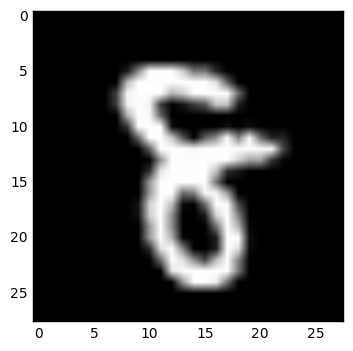

[[0 0 0 0 0 0 0 0 1 0]]


In [68]:
# Print the first image from the training set out
X_batch, y_batch = resample(X_train, y_train_one_hot, n_samples = 1)
plt.imshow(X_batch[0], cmap = plt.get_cmap('gray'))
plt.show()
print(y_batch)

In [69]:
# Normalize the grayscale image so that the values range between -0.5 and 0.5, 
# this is so that the sigmoid activation function does not saturate during training 

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [-0.5, 0.5]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    img_min = np.min(image_data)
    img_max = np.max(image_data)
    a = -0.5
    b = 0.5
    scaled_img = a + ((image_data - img_min) * (b-a))/(img_max - img_min)
    return(scaled_img)

X_train_normalize = normalize_grayscale(X_train)
X_test_normalize = normalize_grayscale(X_test)

In [70]:
# Have a look at the data and before and after the reshape to see if we did it properly 
print(X_train[0])
print(X_train_normalize[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [71]:
# Now flatten the array into a 1 dimension array
X_train_normalize = np.array(X_train_normalize).reshape(60000, 28 * 28)
X_test_normalize = np.array(X_test_normalize).reshape(10000, 28 * 28 )

In [72]:
# See if we did the reshaping correctly
print(X_train_normalize[0])

[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
 -0.5        -0.5        -0.5        -0.5        -0.5        -0.

In [73]:
# Now define a validation set
X_train_normalize, X_validation_normalize, y_train_one_hot, y_validation_one_hot = train_test_split(X_train_normalize, y_train_one_hot, test_size = 0.2)

# Check that the shape is correct
print(X_train_normalize.shape)
print(y_train_one_hot.shape)

(48000, 784)
(48000, 10)


In [97]:
# Now lets define the network again!
n_hidden = 10
# n_hidden_2 = 15
n_classes = 10
n_features = X_train_normalize.shape[1]

# Initialize the weights 
W1_ = np.random.normal(loc = 0, scale = 0.1, size = (n_features, n_hidden))
b1_ = np.zeros(n_hidden)
# W2_ = np.random.normal(loc = 0, scale = 0.1, size = (n_hidden, n_hidden_2))
# b2_ = np.zeros(n_hidden_2)
# W3_ = np.random.normal(loc = 0, scale = 0.1, size = (n_hidden_2, n_classes))
# b3_ = np.zeros(n_classes)

# W2_ = np.random.normal(loc = 0, scale = 1, size = (n_hidden, n_classes))
# b2_ = np.zeros(n_classes)
# Build the layers for the neural network
X, y, = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()
# W3, b3 = Input(), Input()

l1 = Linear(X, W1, b1)
# s1 = Sigmoid(l1)
# l2 = Linear(s1, W2, b2)
# s2 = Sigmoid(l2)
# l3 = Linear(s2, W3, b3)
probs = Softmax(l1)
cost = CrossEntropy(y, probs)

# Define the input layers to the neural network 
feed_dict = {
    X: X_train,
    y: y_train_one_hot,
    W1: W1_,
    b1: b1_
#     W2: W2_,
#     b2: b2_
#     W3: W3_,
#     b3: b3_
}

graph = topological_sort(feed_dict)

In [98]:
batch_size = 5
X_batch, y_batch = resample(X_train_normalize, y_train_one_hot, n_samples = batch_size)
X.value = X_batch
y.value = y_batch
print(X_batch.shape)
print(y_batch.shape)
forward_pass(graph, debug = True)

(5, 784)
(5, 10)
Input to layer is:
[[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
 [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]]
Weights of layer is:
[[-0.06461156  0.0008519  -0.02425677 ...,  0.08459943  0.08628213
   0.01494777]
 [-0.02010472 -0.14911334 -0.02884505 ..., -0.00072358 -0.13153255
   0.00868369]
 [ 0.18851576 -0.07414322 -0.03309469 ..., -0.02557268  0.03838866
  -0.06348232]
 ..., 
 [ 0.01428979 -0.04725193 -0.06415367 ..., -0.15176712  0.0413307
   0.06323723]
 [ 0.11280719  0.02886799 -0.03371613 ..., -0.00248427 -0.01817586
   0.10605946]
 [-0.06143577  0.1108776  -0.15352727 ..., -0.07807271  0.03360923
   0.13976584]]
Bias of layer is:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
XW + b is:
[[-0.9445978  -1.4383392   1.73475364  0.93642449  1.38890624  0.85819315
  -0.07229913  0.80754177 -0.52012355 -1.54362756]
 [-0.27801429 -0.79580898  0.82173161  1.71252721  3.0860

In [25]:
backward_pass(graph, debug = True)

Gradients of cross entropy with respect to y layer is:
[[ -9.94795831  -9.81294809 -26.00542315 -12.65472164 -15.95281936
  -10.39923451  -3.0337511  -45.56715885  -7.40711143 -28.84042258]]
Gradients of cross entropy with respect to softmax layer is:
[[  0.           0.           0.           0.         -15.95281936   0.
    0.           0.           0.           0.        ]]
grad_cost is:
[[  0.           0.           0.           0.         -15.95281936   0.
    0.           0.           0.           0.        ]]
The Jacobian is:
[[ 0.09041824 -0.01024393 -0.00386547 -0.00794353 -0.00630128 -0.0096664
  -0.03313493 -0.00220604 -0.01357117 -0.00348549]
 [-0.01024393  0.09152131 -0.00391865 -0.00805282 -0.00638797 -0.00979939
  -0.03359082 -0.0022364  -0.01375788 -0.00353345]
 [-0.00386547 -0.00391865  0.03697484 -0.00303867 -0.00241045 -0.00369773
  -0.01267524 -0.00084389 -0.00519143 -0.00133332]
 [-0.00794353 -0.00805282 -0.00303867  0.07277743 -0.00495347 -0.00759882
  -0.02604758

In [99]:
# Now lets run the model
from sklearn.utils import shuffle
epochs = 5
steps_per_epoch = 100
batch_size = 128
show_per_step = 1
trainables = [W1, b1]
accuracies = []
for i in range(epochs):
    loss = 0
    X_train_normalize, y_train_one_hot = shuffle(X_train_normalize, y_train_one_hot)
    # First shuffle the data
    for offset in range(0, X_train_normalize.shape[0], batch_size):
       
        # Define the ending points
        end = offset + batch_size
        batch_x, batch_y = X_train_normalize[offset:end], y_train_one_hot[offset:end]
        
        # Reset the values of X and y 
        X.value = batch_x
        y.value = batch_y
#         print(X.value)
#         print(y.value)
        
        # Now run the forward and backward propagation
#         if (end % (batch_size*100) == 0):
#             print("offset is:")
#             print(offset)
#             forward_pass(graph, debug = True) 
#             backward_pass(graph, debug = True)
#             print("Loss is {0}".format(graph[-1].value))
#         else:
#             forward_pass(graph)
#             backward_pass(graph)
#             print("Loss is{0}".format(graph[-1].value))
        
        forward_pass(graph)
        backward_pass(graph)
        
        # Update the weights of or biases and weights
        sgd_update(trainables, learning_rate = 1e-3) 
        loss += graph[-1].value

#     print("Epoch: {}, Loss {:.3f}".format(i + 1, loss/steps_per_epoch))
#     print("Average loss per sample is: {0}".format(loss/(steps_per_epoch * batch_size)))
    
    # Use the validation set to see our accuracy
    X.value = X_validation_normalize
    y.value = y_validation_one_hot 
    forward_pass(graph)
    accuracies.append(graph[-1].accuracy)
    if (i%show_per_step == 0):
        print("Loss of validation set in epoch {0} is: {1}".format(i + 1, graph[-1].value)) 
        print(graph[-1].accuracy)
 

# # Test it on the test set
# X.value = X_test
# y.value = y_test
# forward_pass(graph)
# print("Loss of test set is: {0}".format(graph[-1].value))

/Users/kevinlu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log
/Users/kevinlu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in multiply
/Users/kevinlu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: divide by zero encountered in true_divide
/Users/kevinlu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in true_divide
/Users/kevinlu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in true_divide


Loss of validation set in epoch 1 is: nan
0.0984166666667
Loss of validation set in epoch 2 is: nan
0.0984166666667
Loss of validation set in epoch 3 is: nan
0.0984166666667
Loss of validation set in epoch 4 is: nan
0.0984166666667
Loss of validation set in epoch 5 is: nan
0.0984166666667
